In [30]:
from torchvision import transforms
import clip
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def get_model(model="InceptionV3",device='cpu'):
    transform= transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            
        ])
    if model=="InceptionV3":
        model = models.inception_v3(pretrained=True).to(device)
        model.aux_logits=False
    elif model=="CLIP":
        model, transform = clip.load('ViT-B/32', device=device)
    elif model=="SWAV":
        model=torch.hub.load('facebookresearch/swav','resnet50',pretrained=True).to(device)
        
    model.eval()
    return model,transform




In [6]:
from torchvision.models import Inception_V3_Weights

transform = Inception_V3_Weights.IMAGENET1K_V1.transforms()
transform

ImageClassification(
    crop_size=[299]
    resize_size=[342]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [22]:
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader2,Dataset
import numpy as np

import glob
from PIL import Image

class CelebADataset(Dataset):
    def __init__(self, transform=None,train_paths=None):
        super().__init__()
        self.train_paths = train_paths
        self.transform = transform

    def __len__(self):
        return len(self.train_paths)

    def __getitem__(self, index):
        image_path = self.train_paths[index]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image


def get_loader(transform,dataset="CIFAR100"):
    
    # Create the combined transform
    combined_transform = transforms.Compose([
        transforms.RandomRotation(degrees=(-30, 30)),
        transform,
#         transforms.ToPILImage(),
#         lambda image: augmentations_transforms(image=np.array(image))['image'],
    ])


    if dataset=='CIFAR100':
        train_set = torchvision.datasets.CIFAR100(root='./data/',train=True,download=True,transform=transform) 
        augmented_set = torchvision.datasets.CIFAR100(root='./data/',train=True,transform=combined_transform) 
    elif dataset=='CelebA':
        data_url ='./data/Celeba_512/'
        train_paths = glob.glob(data_url+'*')

        train_set = CelebADataset(transform=transform,train_paths=train_paths)
        augmented_set = CelebADataset(transform=combined_transform,train_paths=train_paths) 
    
    train_loader= DataLoader2(train_set, batch_size=100,num_workers=10)
    augmented_loader= DataLoader2(augmented_set, batch_size=100,num_workers=10)

    return train_loader,augmented_loader



# get_loader(None,"CelebA")

In [23]:
import torch ,numpy as np
from tqdm import tqdm
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def get_features(loader,model,fid_model_type="CLIP",dataset="CIFAR100", device='cpu'):
    all_features = []
    all_labels = []
    with torch.no_grad():
        if dataset=="CIFAR100":
            for images, labels in tqdm(loader):
                if fid_model_type=="CLIP":
                    features = model.encode_image(images.to(device))
                elif fid_model_type=="InceptionV3":
                    features = model(images.to(device)).data
                elif fid_model_type=="SWAV":
                    features = model(images.to(device)).data
                all_features.append(features)
                all_labels.append(labels)
        else:
            for images in tqdm(loader):     
                if fid_model_type=="CLIP":
                    features = model.encode_image(images.to(device))
                elif fid_model_type=="InceptionV3":
                    features = model(images.to(device)).data
                elif fid_model_type=="SWAV":
                    features = model(images.to(device)).data
                all_features.append(features)
            
    return torch.cat(all_features).cpu().numpy()



def plot_images(train_loader):
    # Retrieve a batch of images from the train_loader
    batch_images, _ = next(iter(train_loader))

    # Convert tensor to numpy array and transpose dimensions
    batch_images = batch_images.clone().detach()
    batch_images = batch_images.mul(0.5).add(0.5)  # Unnormalize the images if necessary
    grid_images = vutils.make_grid(batch_images, nrow=8, padding=2, normalize=False)

    # Convert tensor to numpy array and transpose dimensions
    grid_images = F.to_pil_image(grid_images)
    grid_images = grid_images.convert("RGB")
    grid_images = np.array(grid_images)
#     grid_images = np.transpose(grid_images, (x))

    # Display the grid of images
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_images)
    plt.axis('off')
    plt.show()

In [24]:
import numpy as np
import scipy.linalg


def compute_fid(real_features: np.ndarray,
                gen_features: np.ndarray) -> float:
    """Computes the Fréchet Inception Distance."""
    assert real_features.ndim == 2 and gen_features.ndim == 2
    assert real_features.shape[0] == gen_features.shape[0]

    # Feature statistics.
    mu_real = np.mean(real_features, axis=0)
    mu_gen = np.mean(gen_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_gen = np.cov(gen_features, rowvar=False)

    # FID.
    m = np.square(mu_gen - mu_real).sum()
    s, _ = scipy.linalg.sqrtm(np.dot(sigma_gen, sigma_real), disp=False)
    fid = np.real(m + np.trace(sigma_gen + sigma_real - s * 2))

    return np.absolute(fid)





In [31]:
##### clip_FID ######
import clip,torch
fid_model="CLIP"
dataset="CIFAR100"
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model,transform =get_model(fid_model,device)
train_loader,augment_loader = get_loader(transform,dataset)
print("Dataset loaded......",len(train_loader),next(iter(augment_loader))[0].shape)
augmented_feautres =  get_features(augment_loader,model,fid_model_type=fid_model,device=device,dataset=dataset)
train_feautres =  get_features(train_loader,model,fid_model_type=fid_model,device=device,dataset=dataset)
print(train_feautres.shape,augmented_feautres.shape)
print(compute_fid(train_feautres,augmented_feautres))


Files already downloaded and verified
Dataset loaded...... 500 torch.Size([100, 3, 224, 224])


100%|██████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.62it/s]


(50000, 512) (50000, 512)
10.354588103390665


In [32]:
###### InceptionScore ######
fid_model="CLIP"
dataset="CelebA"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model,transform =get_model(fid_model,device)
train_loader,augment_loader = get_loader(transform,dataset)
print("Dataset loaded......",len(train_loader))
augmented_feautres =  get_features(augment_loader,model,fid_model_type=fid_model,device=device,dataset=dataset)
train_feautres =  get_features(train_loader,model,fid_model_type=fid_model,device=device,dataset=dataset)
print(train_feautres.shape,augmented_feautres.shape)
print(compute_fid(train_feautres,augmented_feautres))


Dataset loaded...... 300


100%|██████████████████████████████████████████████████████████████████| 300/300 [00:19<00:00, 15.43it/s]


(30000, 512) (30000, 512)
5.348203980939356


In [34]:
##### SWAV_FID ######
import clip,torch
fid_model="SWAV"
dataset="CelebA"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model,transform =get_model(fid_model,device)
train_loader,augment_loader = get_loader(transform,dataset)
print("Dataset loaded......",len(train_loader))
augmented_feautres =  get_features(augment_loader,model,fid_model_type=fid_model,device=device,dataset=dataset)
train_feautres =  get_features(train_loader,model,fid_model_type=fid_model,device=device,dataset=dataset)
print(train_feautres.shape,augmented_feautres.shape)
print(compute_fid(train_feautres,augmented_feautres))


Using cache found in /data2/home/harshg/.cache/torch/hub/facebookresearch_swav_main


Dataset loaded...... 300


100%|██████████████████████████████████████████████████████████████████| 300/300 [02:53<00:00,  1.73it/s]


(30000, 1000) (30000, 1000)
0.26431994522652613


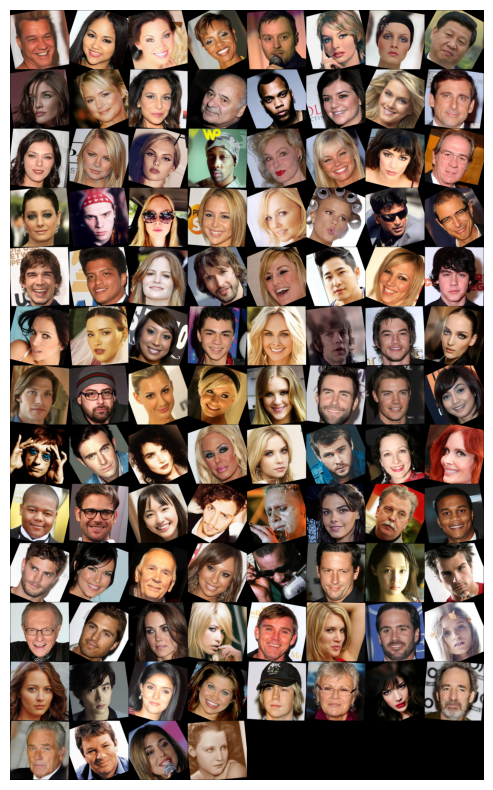

In [36]:
import torchvision.transforms.functional as F
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

def plot_images(train_loader):
    # Retrieve a batch of images from the train_loader
    try:
        batch_images, _ = next(iter(train_loader))
    except:
        batch_images = next(iter(train_loader))
    # Convert tensor to numpy array and transpose dimensions
    batch_images = batch_images.clone().detach()
    batch_images = batch_images.mul(0.5).add(0.5)  # Unnormalize the images if necessary
    grid_images = vutils.make_grid(batch_images, nrow=8, padding=2, normalize=False)

    # Convert tensor to numpy array and transpose dimensions
    grid_images = F.to_pil_image(grid_images)
    grid_images = grid_images.convert("RGB")
    grid_images = np.array(grid_images)
#     grid_images = np.transpose(grid_images, (x))

    # Display the grid of images
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_images)
    plt.axis('off')
    plt.show()

plot_images(augment_loader)


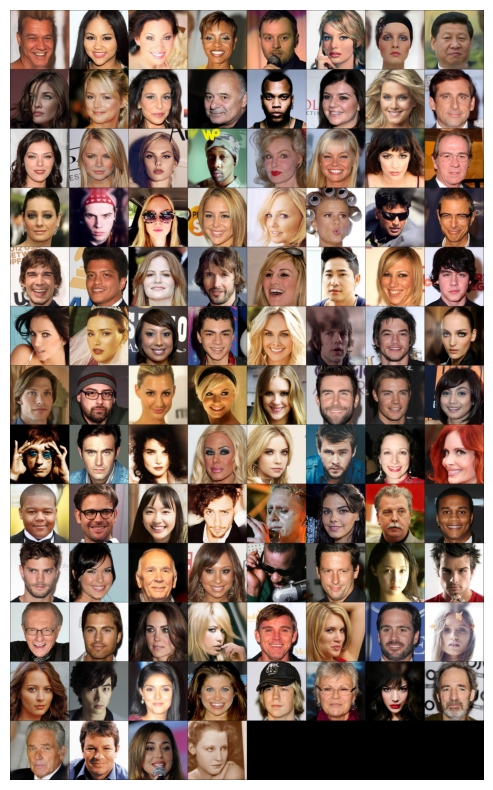

In [37]:
plot_images(train_loader)

In [ ]:
model=torch.hub.load('facebookresearch/swav','resnet50',pretrained=True)

In [ ]:
model.forward(x).shape

In [ ]:
x = next(iter(train_loader))[0]